<center><h1 style="font-size:40px;">Project<br> cGAN 128x128
</h1></center>

## Project Description
This project aims to develop a Conditional Generative Adversarial Network (cGAN) for image sequence prediction. The goal is to generate the last frame of a sequence given the very first frame as input(condition). This involves implementing a cGAN and conditioning the generation process on the first frame of the sequence to accurately produce the corresponding last frame.

## Objectives
Implement a cGAN: Develop and train a conditional Generative Adversarial Network (cGAN) to generate images.
Conditional Generation: Condition the generation process on the first image of the sequence to generate the last frame.

In [1]:
%load_ext autoreload
%autoreload 2
import sys,os
sys.path.append(os.path.dirname(os.path.realpath('...../Project/utils')))

In [ ]:
import torch
import torch.nn as nn
import os
from config import LabConfig
import torchmetrics
import transforms as T
import torchvision
from utils.plot import GAN
import torchvision.datasets as dset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, Grayscale
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import utils
from glob import glob
from utils import utils
import numpy as np
from PIL import Image
import random
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchsummary import summary
import torch.optim as optim
import torch.nn.init as init
from utils.dataset import LastFramePredictorDataset
from skimage.metrics import structural_similarity as ssim
from torch.optim.lr_scheduler import ReduceLROnPlateau

cfg = LabConfig()
cfg.todict()

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
# Class definition to extract first and last frame.
# Total of 300 pairs of image frames

class CGAN_Dataset(LastFramePredictorDataset):
    def __init__(self, data_dir, transform=None, target_transform=None, augmentation = None ):
        super().__init__(data_dir)
        self.transform = transform
        self.target_transform = target_transform
        self.augmentation = augmentation 
        self.first_frames, self.last_frames = self.get_first_last_frames()

    def get_first_last_frames(self):
        image_list, _ = self.image_sequence(sorted(glob(os.path.join(self.data_dir, '*.png'))))
        image_dict = {}

        for img_name in image_list:
            action_id, class_id, color_id, frame_id = img_name.split(".")[0].split("_")
            key = (action_id, color_id, class_id)

            if key not in image_dict:
                image_dict[key] = []

            image_dict[key].append(img_name)

        first_frames = []
        last_frames = []

        for key, images in image_dict.items():
            first_frames.append(images[0])
            last_frames.append(images[-1])

        assert len(first_frames) == len(last_frames)

        return first_frames, last_frames

    def __getitem__(self, index):
        first_path = os.path.join(self.data_dir, self.first_frames[index])
        last_path = os.path.join(self.data_dir, self.last_frames[index])

        first_frame = Image.open(first_path)
        last_frame = Image.open(last_path)
        
        if self.augmentation is not None:
            first_frame, last_frame = self.augmentation(first_frame, last_frame)

        if self.transform is not None:
            first_frame = self.transform(first_frame)
        if self.target_transform is not None:
            last_frame = self.target_transform(last_frame)

        return first_frame, last_frame

    def __len__(self):
        return len(self.first_frames)


### Dataset Augmentation


In [93]:
# Dataset Augmentation

train_transform1 = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Contrast 
train_transform2 = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.ColorJitter(contrast=0.1),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Gaussian blur
train_transform3 = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=1),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


### Dataset and Dataloader

In [95]:
# Create new dataset from __main dataset along with the above augmentation. 
# (New Dataset = __main DS + Transformed[Train dataset + Validation dataset + testing dataset]) 

dataset1 = CGAN_Dataset(
    data_dir=cfg.training_img_dir,
    transform=train_transform1,
    target_transform=train_transform1,
    augmentation= None,
)

dataset2 = CGAN_Dataset(
    data_dir=cfg.training_img_dir,
    transform=train_transform2,
    target_transform=train_transform2,
    augmentation= None,
)

dataset3 = CGAN_Dataset(
    data_dir=cfg.training_img_dir,
    transform=train_transform3,
    target_transform=train_transform3,
    augmentation= None,
)
## Transformed Validation dataset
val_dataset1 = CGAN_Dataset(
    data_dir=cfg.validation_img_dir,
    transform=train_transform1,
    target_transform=train_transform1,
    augmentation= None,
)

val_dataset2 = CGAN_Dataset(
    data_dir=cfg.validation_img_dir,
    transform=train_transform2,
    target_transform=train_transform2,
    augmentation= None,
)

val_dataset3 = CGAN_Dataset(
    data_dir=cfg.validation_img_dir,
    transform=train_transform3,
    target_transform=train_transform3,
    augmentation= None,
)
test_dataset1 = CGAN_Dataset(
    data_dir=cfg.testing_img_dir,
    transform=train_transform1,
    target_transform=train_transform1,
    augmentation= None,
)

test_dataset2 = CGAN_Dataset(
    data_dir=cfg.testing_img_dir,
    transform=train_transform2,
    target_transform=train_transform2,
    augmentation= None,
)

test_dataset3 = CGAN_Dataset(
    data_dir=cfg.testing_img_dir,
    transform=train_transform3,
    target_transform=train_transform3,
    augmentation= None,
)

combined_dataset = ConcatDataset([dataset1, dataset2,dataset3, val_dataset1, val_dataset2, val_dataset3,
                                  test_dataset1, test_dataset2, test_dataset3])

In [107]:
## Dataset split for test-train 

first_dataset_percentage = 0.7
total_size = len(combined_dataset)
first_dataset_size = int(first_dataset_percentage * total_size)
second_dataset_size = int(0.2 * total_size)
third_dataset_size = total_size - first_dataset_size - second_dataset_size

first_dataset, second_dataset, third_dataset = random_split(combined_dataset, [first_dataset_size, second_dataset_size, third_dataset_size])

train_dataloader = torch.utils.data.DataLoader(
    first_dataset,
    batch_size=21,
    shuffle=True,
    num_workers=0
)

val_dataloader = torch.utils.data.DataLoader(
    second_dataset,
    batch_size=21,
    shuffle=False,
    num_workers=0
)  

test_dataloader = torch.utils.data.DataLoader(
    third_dataset,
    batch_size=21,
    shuffle=False,
    num_workers=0
)

In [108]:
print('Dataset',len(first_dataset),len(second_dataset), len(third_dataset))
print('Dataloader',len(train_dataloader),len(val_dataloader), len(test_dataloader))


Dataset 882 252 126
Dataloader 42 12 6


### Visualize Data

torch.Size([21, 3, 128, 128]) torch.Size([21, 3, 128, 128])
torch.float32 torch.float32


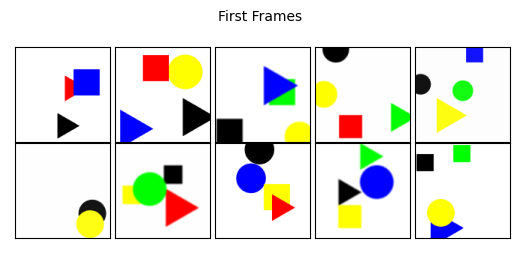

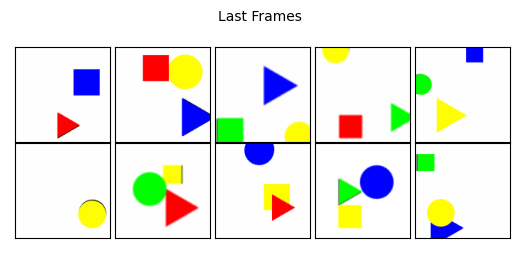

In [109]:
## Display
t_x, t_y = next(iter(train_dataloader))
t_x, t_y = t_x.cpu(),t_y.cpu()
print(t_x.shape, t_y.shape)
print(t_x.dtype, t_y.dtype)
GAN.frame_data(t_x, t_y)

### Model Implementation

In [110]:
## Generator model

class Gen(nn.Module):
    def __init__(self, num_classes:int=3,input_shape=(128,128),latent_dim = 48, **kwargs):
        super(Gen, self).__init__()
        
        #noise
        self.noise_conv1 = self.noise_conv(latent_dim, 64)
        self.noise_conv2 = self.noise_conv(64,100 )
        
        ## Encoder
        self.conv1 = self.Encoder(num_classes + 100, 64)
        self.conv2 = self.Encoder(64, 128)
        self.conv3 = self.Encoder(128, 256)
        self.conv4 = self.Encoder(256, 512)
        self.conv5 = self.Encoder(512, 512)
        self.conv6 = self.Encoder(512, 512)
        self.conv7 = self.Encoder(512, 512)
        
        # Decoder
        self.upconv8 = self.Decoder(512,512, dropout=True)
        self.upconv7 = self.Decoder(1024,512, dropout=True)
        self.upconv6 = self.Decoder(1024,512, dropout=True)##
        self.upconv5 = self.Decoder(1024,512, dropout=True)##
        self.upconv4 = self.Decoder(768,256, dropout=True)##
        self.upconv3 = self.Decoder(384,128, dropout=True)##
        self.upconv2 = self.Decoder(192,64)
        self.upconv1 = self.Decoder_last(64,3)
    

    def forward(self, x):
        noise = torch.normal(0, 1, size=(21, 48, 128, 128)).to(torch.float).to(device)
        noise_conv1 = self.noise_conv1(noise)
        noise_conv2 = self.noise_conv2(noise_conv1)
        x = torch.cat([x, noise_conv2], dim=1)

        # Downsample
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)
        conv6 = self.conv6(conv5)
        conv7 = self.conv7(conv6)
        
        
        # Upsample
        upconv8 = self.upconv8(conv7)
        upconv7 = self.upconv7(torch.cat([upconv8, conv6], 1))
        upconv6 = self.upconv6(torch.cat([upconv7, conv5], 1))
        upconv5 = self.upconv5(torch.cat([upconv6, conv4], 1))
        upconv4 = self.upconv4(torch.cat([upconv5, conv3], 1))
        upconv3 = self.upconv3(torch.cat([upconv4, conv2], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, conv1], 1))
        upconv1 = self.upconv1(upconv2)

        return upconv1

    def Encoder(self, in_channels, out_channels):

        return nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),

        )

    def Decoder(self, in_channels, out_channels, dropout=False):
        layers = [
            torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        ]
        
        if dropout:
            layers.append(torch.nn.Dropout2d(0.5))  

        return nn.Sequential(*layers)
      
    def Decoder_last(self, in_channels, out_channels):
        return nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1), 
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.Tanh(),  
        )
    
    def noise_conv(self, in_channels, out_channels):
        return nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),   
        )

In [111]:
## Discriminator model (Concept obtained from concept of PatchGaN)

class Disc(nn.Module):
    def __init__(self, num_classes=3, input_shape=(128, 128), dropout_prob=0.3, **kwargs): 
        super(Disc, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64), #### new
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=dropout_prob), 
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Dropout2d(p=dropout_prob),
            nn.Conv2d(256, 512, kernel_size=4, padding=0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Dropout2d(p=dropout_prob),
            nn.Conv2d(512, 1, kernel_size=4, padding=0),
            nn.BatchNorm2d(1),  #### new
            nn.AvgPool2d(kernel_size=14, stride=14),
            nn.Sigmoid()
        ).to(torch.float)
        

    def forward(self, x):
        return self.model(x)


## Training

In [55]:
## Initializing Xavier weights 

def xavier_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            init.zeros_(m.bias.data)
    elif classname.find('BatchNorm') != -1:
        init.ones_(m.weight.data)
        init.zeros_(m.bias.data)

In [ ]:
# Model Intilialiasation

## Generator
generator = Gen()
generator = generator.to(device)
generator.apply(xavier_init)

## Discriminator
discriminator = Disc()
discriminator = discriminator.to(device)
discriminator.apply(xavier_init)

criterion_gen = nn.MSELoss()
criterion = nn.BCELoss()
criterion_gen = criterion_gen.to(device)
criterion = criterion.to(device)

initial_gen_lr = 0.0009
initial_disc_lr = 0.0008

g_optimizer = optim.Adam(generator.parameters(), lr=initial_gen_lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=initial_disc_lr, betas=(0.5, 0.999))

## learning rate schedulers with patience 
gen_scheduler = ReduceLROnPlateau(g_optimizer, mode='min', factor=0.7, patience=15, verbose=True)
disc_scheduler = ReduceLROnPlateau(d_optimizer, mode='min', factor=0.7, patience=15, verbose=True)


In [113]:
## Generator train function

def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion, first_frame):
    g_optimizer.zero_grad()
    generated_image = generator(first_frame)
    generated_image_concat = torch.cat([generated_image, first_frame], dim=1)
    disc_fake = discriminator(generated_image_concat)    
    d1_loss_generator = criterion(disc_fake, torch.ones_like(disc_fake).to(device))
    d2_loss_generator = criterion_gen(last_frame, generated_image)
    gen_loss = d1_loss_generator + d2_loss_generator
    gen_loss.backward()
    g_optimizer.step()
    
    return gen_loss.item()

## Discriminitator train function

def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, first_frame, last_frame):
    d_optimizer.zero_grad()
    generated_image = generator(first_frame)
    generated_image_concat = torch.cat([generated_image, first_frame], dim=1) ## Combining generated image and first frame 
    disc_fake = discriminator(generated_image_concat.detach())
    disc_fake_loss = criterion(disc_fake, torch.zeros_like(disc_fake).to(device))

    real_concat = torch.cat([last_frame, first_frame], dim=1)
    disc_real = discriminator(real_concat)
    disc_real_loss = criterion(disc_real, torch.ones_like(disc_real).to(device))
    
    disc_loss = disc_real_loss + disc_fake_loss
    disc_loss.backward()
    d_optimizer.step()
    
    return disc_loss.item()

 

In [115]:
## Validation

def validation_step(generator,discriminator, val_dataloader, criterion, epoch, device): 
    generator.eval()
    discriminator.eval()
    total_val_gen_loss = 0
    total_val_disc_loss = 0
    with torch.no_grad():
        for val_batch_idx, (val_first_frame, val_last_frame) in enumerate(val_dataloader):
            val_first_frame, val_last_frame = val_first_frame.to(device), val_last_frame.to(device)
            val_first_frame = val_first_frame.float()
            val_last_frame = val_last_frame.float()
            
#### Generator
            val_generated_image = generator(val_first_frame)
            val_gen_loss = criterion_gen(val_generated_image, val_last_frame)
            
#### Discriminiator           
            val_generated_image_concat = torch.cat([val_generated_image, val_first_frame], dim=1)
            val_disc_fake = discriminator(val_generated_image_concat.detach())
            val_disc_fake_loss = criterion(val_disc_fake, torch.zeros_like(val_disc_fake).to(device))

            val_real_concat = torch.cat([val_last_frame, val_first_frame], dim=1)
            val_disc_real = discriminator(val_real_concat)
            val_disc_real_loss = criterion(val_disc_real, torch.ones_like(val_disc_real).to(device))
            val_disc_loss = val_disc_real_loss + val_disc_fake_loss
            
            total_val_gen_loss += val_gen_loss.item()
            total_val_disc_loss += val_disc_loss.item()
            
        avg_val_gen_loss = total_val_gen_loss / len(val_dataloader.dataset)
        avg_val_disc_loss = total_val_disc_loss / len(val_dataloader.dataset)

        print(f'\033[94mEpoch {epoch + 1}/{num_epoch}, Val Disc Loss: {avg_val_disc_loss * 100}, Val Gen Loss: {avg_val_gen_loss * 100}\033[0m')
        
        return (avg_val_gen_loss,avg_val_disc_loss)
       

In [116]:
## Visualisation function declaration while training 

## Visual inspection of frames
def validation_plot(generator, val_dataloader):
    for batch_idx, (val_first_frame, val_last_frame) in enumerate(val_dataloader):
        val_first_frame, val_last_frame = val_first_frame.to(device), val_last_frame.to(device)
        val_first_frame=val_first_frame.float()
 
        with torch.no_grad():
            val_generated_image = generator(val_first_frame)
        GAN.results(val_first_frame.cpu(), val_last_frame.cpu(), val_generated_image.cpu(), nimages=4, nrow=5)
        break

# Plot Losses graphs - Gen and Disc
def plot_loss(disc_loss, gen_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_loss, label='Generator Loss', color='blue')
    plt.plot(disc_loss, label='discriminator_losses', color='orange')
    plt.title('Generator Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return

# Plot Losses graphs - both training and validation [ Gen() and Disc() ]
def plot_loss_all(train_disc_loss, train_gen_loss, val_disc_loss, val_gen_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(train_gen_loss, label='train_Generator Loss', color='blue')
    plt.plot(train_disc_loss, label='train_discriminator_losses', color='orange')
    plt.plot(val_gen_loss, label='val_Generator Loss', color='red')
    plt.plot(val_disc_loss, label='val_discriminator_losses', color='green')
    plt.title('Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return

## L1 Loss metric inspection while training
def L1Loss_metric(dataloader, generator):
    total_l1_loss = 0.0

    for batch_idx, (ff, lf) in enumerate(dataloader):
        ff, lf = ff.to(device), lf.to(device)
        ff = ff.float()
        lf = lf.float()

        generator.eval()
        with torch.no_grad():
            g_image = generator(ff)

        # L1 Loss for each pair
        l1_loss = F.l1_loss(g_image, lf)
        total_l1_loss += l1_loss.item()
    average_l1_loss = total_l1_loss / len(dataloader.dataset)
  
    return average_l1_loss

In [119]:
## Initalising Lists 
discriminator_losses_2 = []
generator_losses_2 = []
validation_gen_losses_2 = []
validation_disc_losses_2 = []

Current Disc Learning Rate: 0.0008
Current Gen Learning Rate: 0.0004
Epoch 1/100, Discriminator Loss: 6.601410725760082, Generator Loss: 3.477774631409418
Epoch 1/100, Val Disc Loss: 6.600785965011233, Val Gen Loss: 0.20018285583882103
Final Average L1 Loss: Test-: 19.704722577617282 Val-: 20.078806472676142 Train-: 17.250651987839717
Epoch 2/100, Discriminator Loss: 6.601409968875703, Generator Loss: 3.472205395060602
Epoch 2/100, Val Disc Loss: 6.600957493933421, Val Gen Loss: 0.19462124281932439
Final Average L1 Loss: Test-: 19.063763616103973 Val-: 19.40565715943064 Train-: 16.702311556963693
Epoch 3/100, Discriminator Loss: 6.601408711907005, Generator Loss: 3.46728778209816
Epoch 3/100, Val Disc Loss: 6.601318953529237, Val Gen Loss: 0.18459025563465223
Final Average L1 Loss: Test-: 18.457417627648702 Val-: 18.367687949822063 Train-: 15.996591929270297
Epoch 4/100, Discriminator Loss: 6.6014079550226255, Generator Loss: 3.461931601943883
Epoch 4/100, Val Disc Loss: 6.601380497690

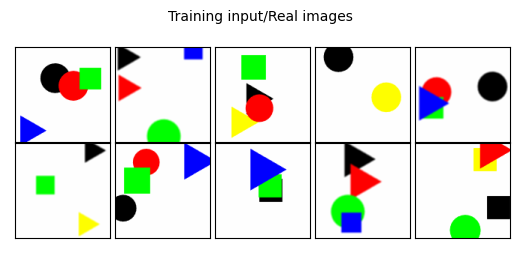

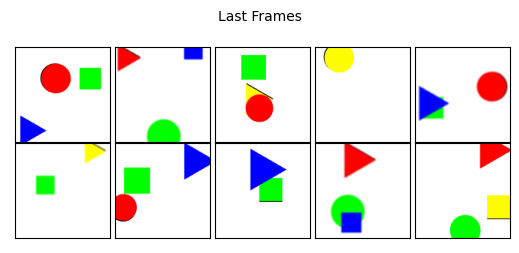

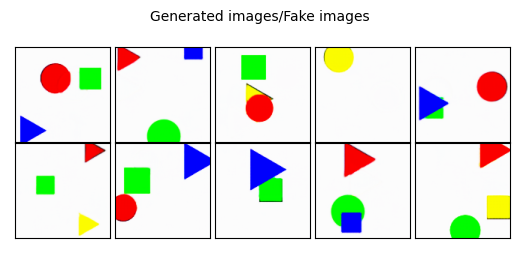

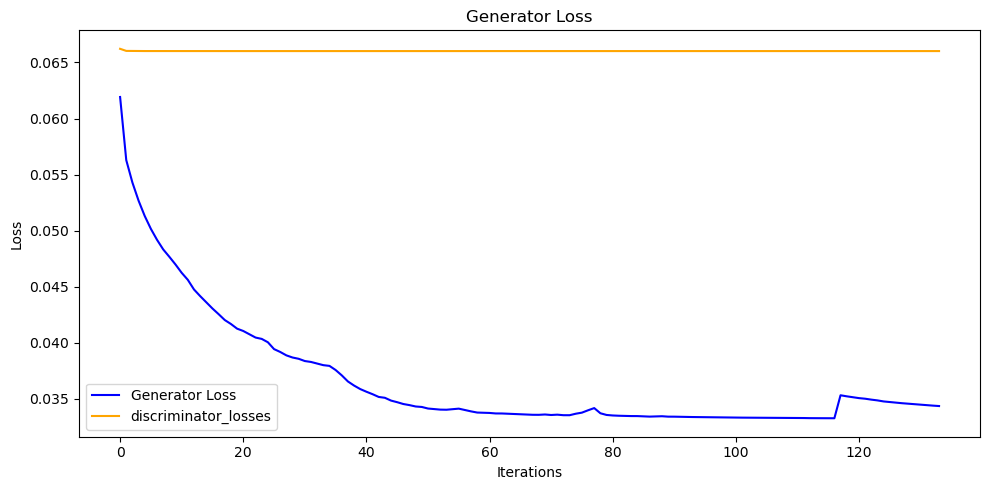

Epoch 11/100, Discriminator Loss: 6.601408211822683, Generator Loss: 3.4333946753521354
Epoch 11/100, Val Disc Loss: 6.601197047839088, Val Gen Loss: 0.14842490310825052
Final Average L1 Loss: Test-: 14.725047503671949 Val-: 14.909131688967584 Train-: 12.3572107531181
Epoch 12/100, Discriminator Loss: 6.601405792495832, Generator Loss: 3.430424046083913
Epoch 12/100, Val Disc Loss: 6.601274297350929, Val Gen Loss: 0.1516595416303192
Final Average L1 Loss: Test-: 15.298412107522525 Val-: 15.17014563201912 Train-: 12.571095402379967
Epoch 13/100, Discriminator Loss: 6.601405332958887, Generator Loss: 3.4272304940926515
Epoch 13/100, Val Disc Loss: 6.601424633510529, Val Gen Loss: 0.15236589658473218
Final Average L1 Loss: Test-: 15.353401975026207 Val-: 15.345013863037503 Train-: 12.160492300683138
Epoch 14/100, Discriminator Loss: 6.601405616790529, Generator Loss: 3.422827886886337
Epoch 14/100, Val Disc Loss: 6.601625349786547, Val Gen Loss: 0.1506643391968239
Final Average L1 Loss: T

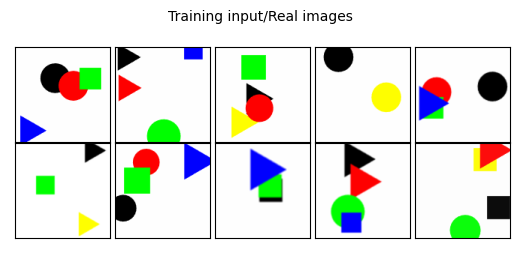

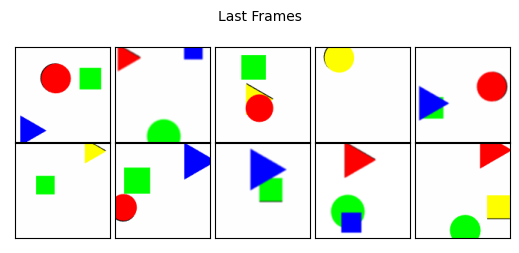

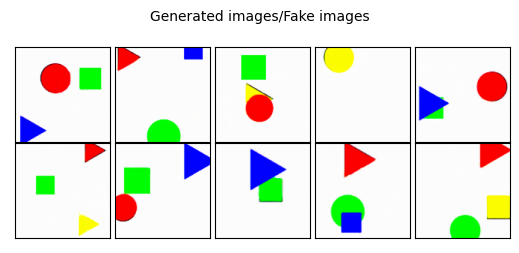

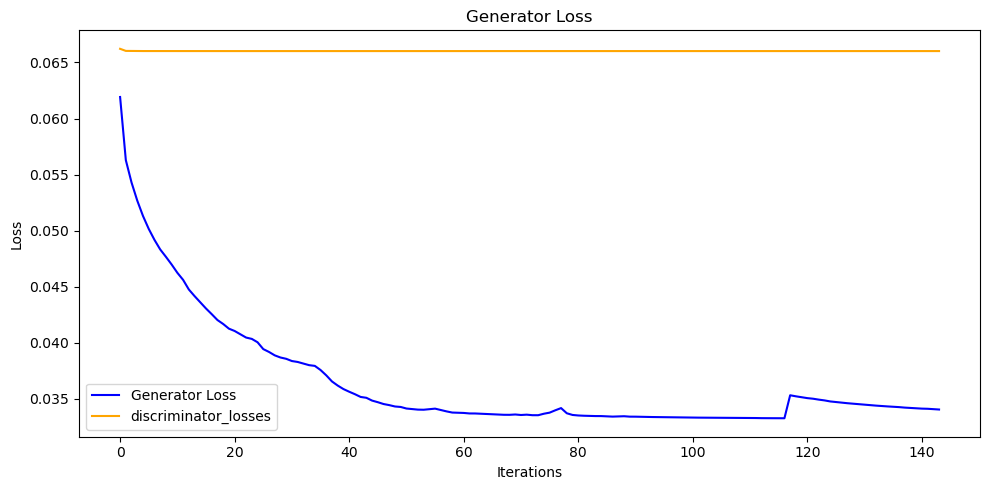

Epoch 21/100, Discriminator Loss: 6.601404346306038, Generator Loss: 3.4040074026773843
Epoch 21/100, Val Disc Loss: 6.601393837777395, Val Gen Loss: 0.12850540113591014
Final Average L1 Loss: Test-: 12.891452966464891 Val-: 12.860364310206874 Train-: 10.27888498034607
Epoch 22/100, Discriminator Loss: 6.601404224663905, Generator Loss: 3.401687795342772
Epoch 22/100, Val Disc Loss: 6.601578139123462, Val Gen Loss: 0.12587410737834281
Final Average L1 Loss: Test-: 12.712919020227023 Val-: 12.609886434224864 Train-: 9.54902458454476
Epoch 23/100, Discriminator Loss: 6.601403981379642, Generator Loss: 3.399582413318746
Epoch 23/100, Val Disc Loss: 6.601267390780979, Val Gen Loss: 0.12230053544044495
Final Average L1 Loss: Test-: 12.261265859244363 Val-: 12.261044928833606 Train-: 9.176269840964384
Epoch 24/100, Discriminator Loss: 6.601403900284886, Generator Loss: 3.3975364669920904
Epoch 24/100, Val Disc Loss: 6.60141838921441, Val Gen Loss: 0.12375115461292721
Final Average L1 Loss: T

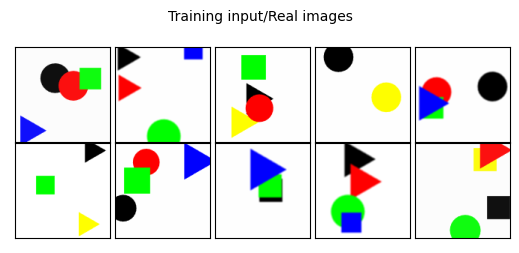

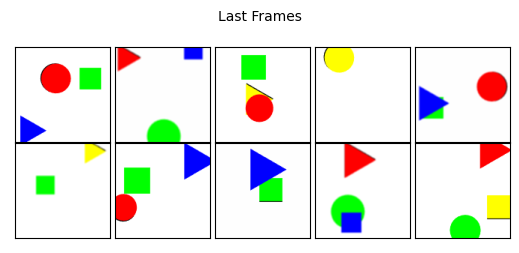

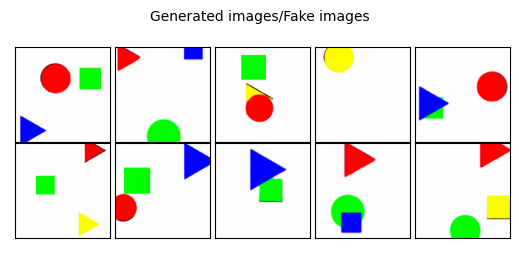

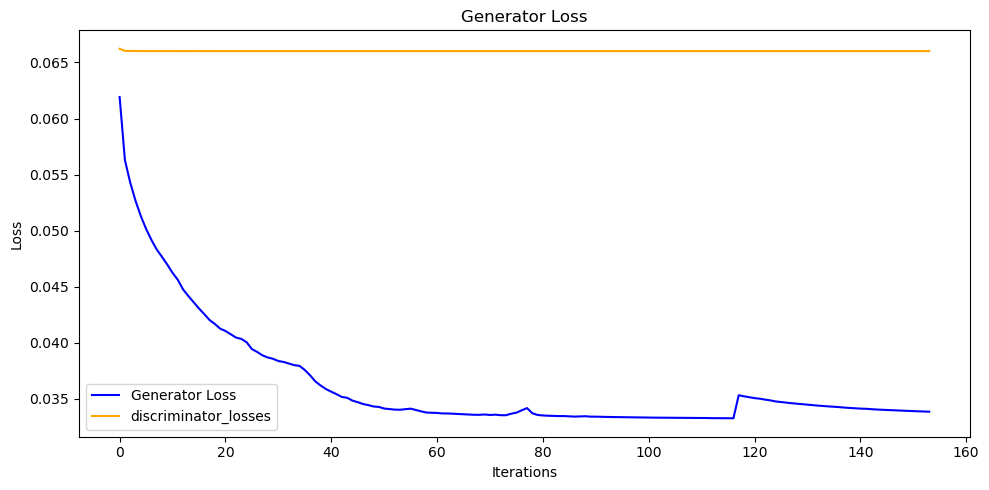

Epoch 31/100, Discriminator Loss: 6.601403616453244, Generator Loss: 3.3845449791473596
Epoch 31/100, Val Disc Loss: 6.60133787563869, Val Gen Loss: 0.11001656511946328
Final Average L1 Loss: Test-: 11.04508216182391 Val-: 10.99316868931055 Train-: 7.768738962067904
Epoch 32/100, Discriminator Loss: 6.601403670516415, Generator Loss: 3.3829276861787654
Epoch 32/100, Val Disc Loss: 6.6014188622671455, Val Gen Loss: 0.11196498286038163
Final Average L1 Loss: Test-: 11.515838818417654 Val-: 11.272403219389536 Train-: 8.190754661653317
Epoch 33/100, Discriminator Loss: 6.6014034407479425, Generator Loss: 3.38164292901011
Epoch 33/100, Val Disc Loss: 6.601330354100182, Val Gen Loss: 0.11310774744266557
Final Average L1 Loss: Test-: 11.61347690319258 Val-: 11.448255547928431 Train-: 8.110412652023525
Epoch 34/100, Discriminator Loss: 6.601403697547998, Generator Loss: 3.380346338765151
Epoch 34/100, Val Disc Loss: 6.601400365905157, Val Gen Loss: 0.10221708225943739
Final Average L1 Loss: Te

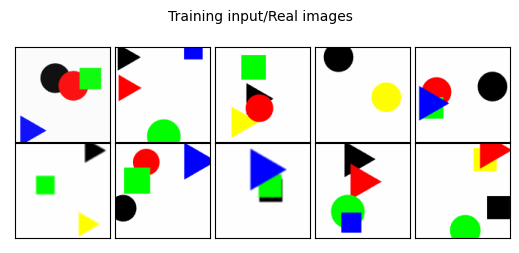

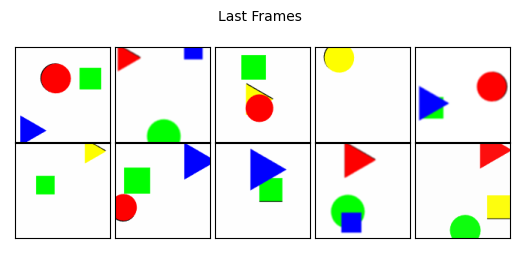

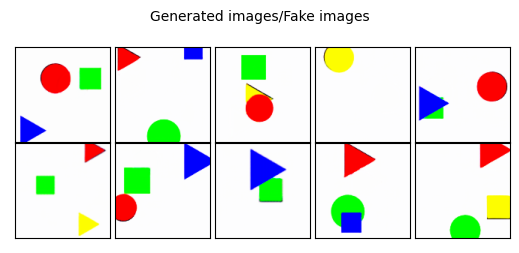

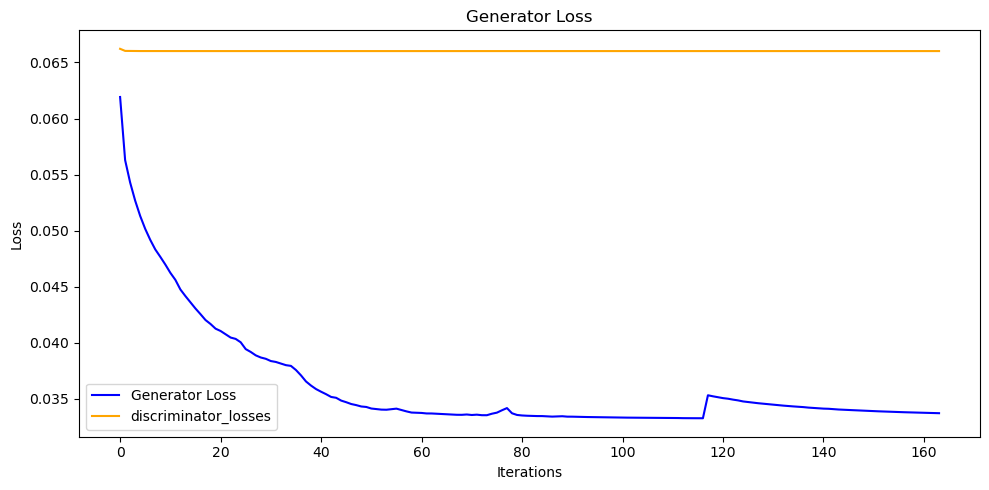

Epoch 41/100, Discriminator Loss: 6.601403278558432, Generator Loss: 3.3715715281276744
Epoch 41/100, Val Disc Loss: 6.601335652290828, Val Gen Loss: 0.10313873755789939
Final Average L1 Loss: Test-: 10.141361475227372 Val-: 10.311285713835368 Train-: 7.382544135577689
Epoch 42/100, Discriminator Loss: 6.60140342723215, Generator Loss: 3.3706464464702304
Epoch 42/100, Val Disc Loss: 6.601420328730629, Val Gen Loss: 0.10090886748262815
Final Average L1 Loss: Test-: 9.83510883377185 Val-: 10.017465970050248 Train-: 6.960059934276707
Epoch 43/100, Discriminator Loss: 6.601403129884716, Generator Loss: 3.3703379822966735
Epoch 43/100, Val Disc Loss: 6.601368813287644, Val Gen Loss: 0.09340382040670467
Final Average L1 Loss: Test-: 9.25145259807034 Val-: 9.367595175428995 Train-: 6.484228678368657
Epoch 44/100, Discriminator Loss: 6.601402886600451, Generator Loss: 3.3679145804338173
Epoch 44/100, Val Disc Loss: 6.601367346824162, Val Gen Loss: 0.09166796817370351
Final Average L1 Loss: Tes

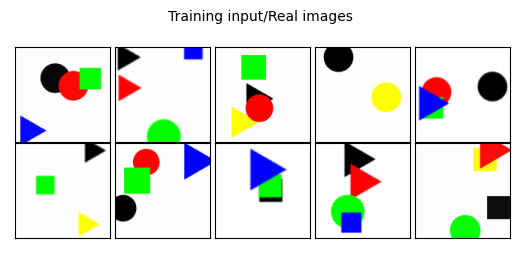

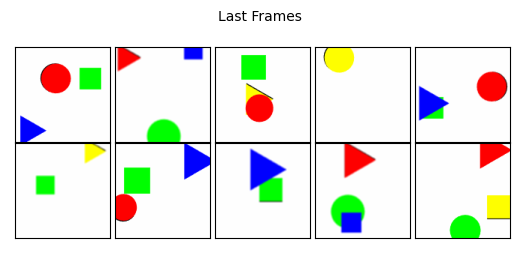

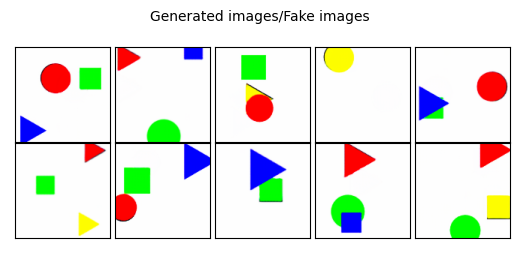

Early stopping at epoch 50 as there is no improvement for 10 consecutive epochs.


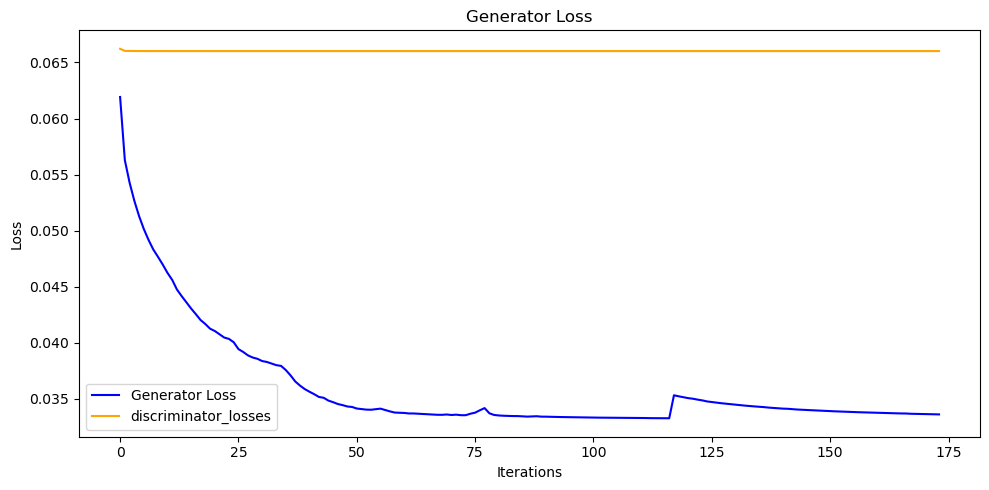

Epoch 51/100, Discriminator Loss: 6.6014035894216585, Generator Loss: 3.3617621443979866
Epoch 51/100, Val Disc Loss: 6.601400507820977, Val Gen Loss: 0.0910375766190035
Final Average L1 Loss: Test-: 9.084800110449867 Val-: 9.132862453245455 Train-: 5.901500080076475
Epoch 52/100, Discriminator Loss: 6.60140331910581, Generator Loss: 3.3618583768403454
Epoch 52/100, Val Disc Loss: 6.601311006243267, Val Gen Loss: 0.0808456361973806
Final Average L1 Loss: Test-: 7.9834295643700495 Val-: 7.931830043653174 Train-: 5.253489802923062
Epoch 53/100, Discriminator Loss: 6.601402913632036, Generator Loss: 3.3602551808432928
Epoch 53/100, Val Disc Loss: 6.601342606166052, Val Gen Loss: 0.08978100367895667
Final Average L1 Loss: Test-: 9.089024693128609 Val-: 8.92477139594063 Train-: 6.020829396199883
Epoch 54/100, Discriminator Loss: 6.601402900116243, Generator Loss: 3.3587931708143413
Epoch 54/100, Val Disc Loss: 6.6013492762096355, Val Gen Loss: 0.08559445407064188
Final Average L1 Loss: Test

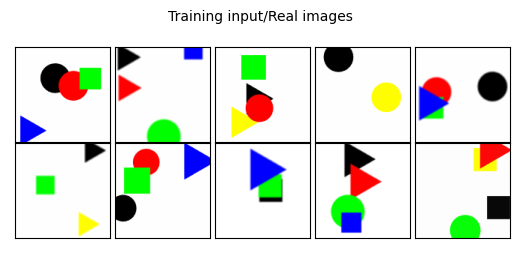

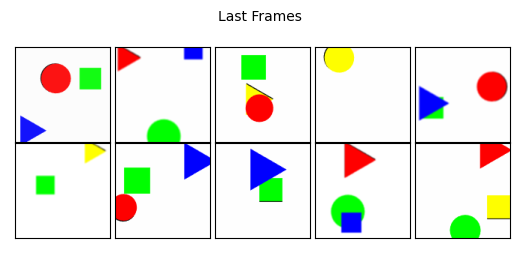

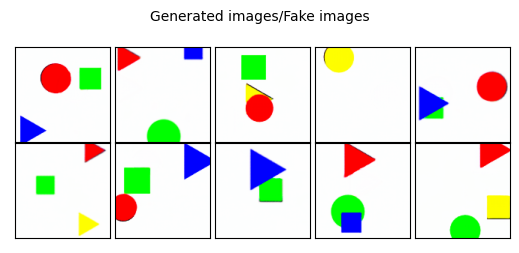

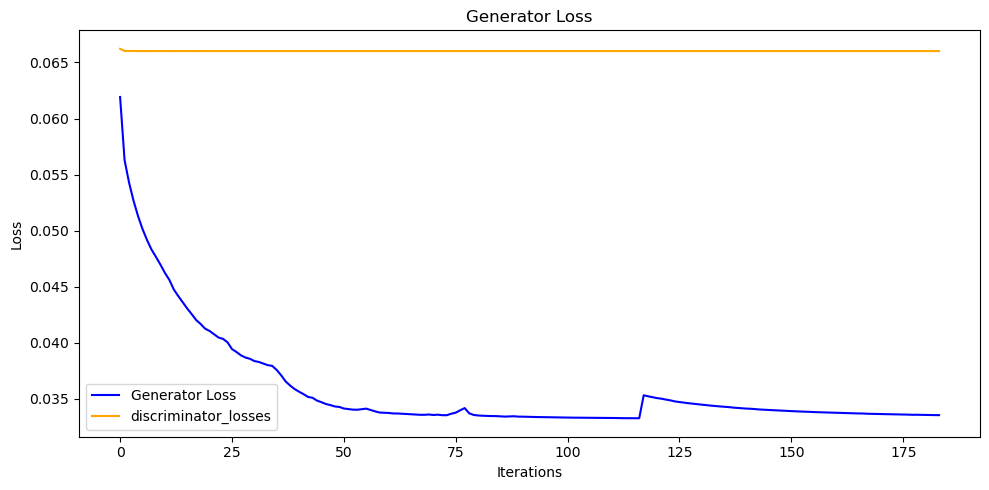

Epoch 61/100, Discriminator Loss: 6.601402778474111, Generator Loss: 3.3549337362756533
Epoch 61/100, Val Disc Loss: 6.601320278076899, Val Gen Loss: 0.08269956017593069
Final Average L1 Loss: Test-: 8.254706312621398 Val-: 8.18648918842276 Train-: 5.150006169584198
Epoch 62/100, Discriminator Loss: 6.601402940663621, Generator Loss: 3.3542530809670614
Epoch 62/100, Val Disc Loss: 6.601388066534013, Val Gen Loss: 0.08144193728055273
Final Average L1 Loss: Test-: 8.11647039852918 Val-: 8.212772885426169 Train-: 5.243228919499991
Epoch 63/100, Discriminator Loss: 6.601402643316187, Generator Loss: 3.354816844944511
Epoch 63/100, Val Disc Loss: 6.601359872590928, Val Gen Loss: 0.07583621024553265
Final Average L1 Loss: Test-: 7.510900881791872 Val-: 7.587309579350173 Train-: 4.925159969770449
Epoch 64/100, Discriminator Loss: 6.601402670347771, Generator Loss: 3.3534286311424237
Epoch 64/100, Val Disc Loss: 6.601408738938589, Val Gen Loss: 0.07674117380427936
Final Average L1 Loss: Test-:

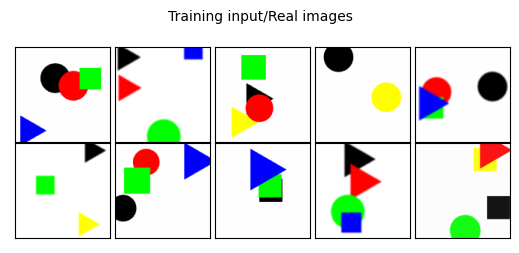

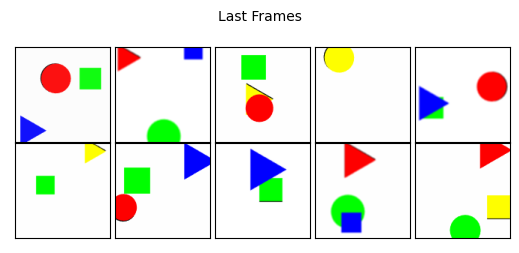

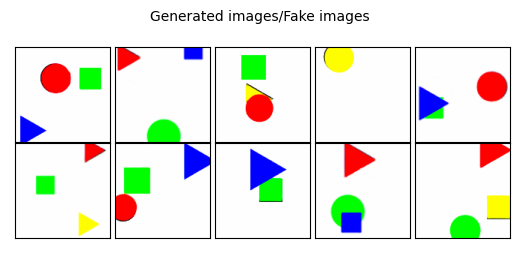

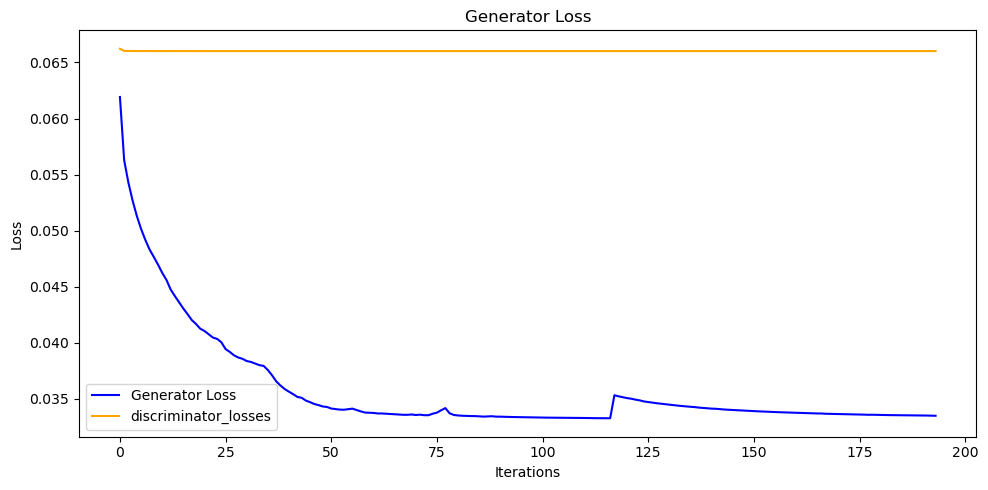

Epoch 71/100, Discriminator Loss: 6.601402724410941, Generator Loss: 3.349392126206638
Epoch 71/100, Val Disc Loss: 6.601382058764262, Val Gen Loss: 0.07144319972703381
Final Average L1 Loss: Test-: 6.501506348805767 Val-: 7.122247405941525 Train-: 4.413950646638262
Epoch 72/100, Discriminator Loss: 6.601403156916301, Generator Loss: 3.3499075374365397
Epoch 72/100, Val Disc Loss: 6.601375246804858, Val Gen Loss: 0.07651914354591142
Final Average L1 Loss: Test-: 6.783306007347409 Val-: 7.553375178268031 Train-: 4.47754414494481
Epoch 73/100, Discriminator Loss: 6.601402832537281, Generator Loss: 3.3491075714699536
Epoch 73/100, Val Disc Loss: 6.601357128885057, Val Gen Loss: 0.07120447809852305
Final Average L1 Loss: Test-: 6.617646117413801 Val-: 7.16222668184884 Train-: 4.281242211220486
Epoch 74/100, Discriminator Loss: 6.601402967695207, Generator Loss: 3.348349200354682
Epoch 74/100, Val Disc Loss: 6.6013626162967975, Val Gen Loss: 0.0826307361768115
Final Average L1 Loss: Test-: 

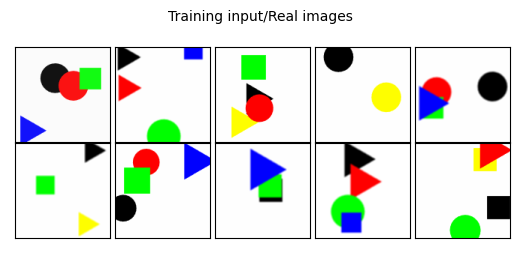

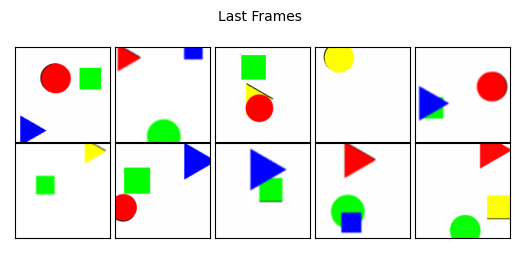

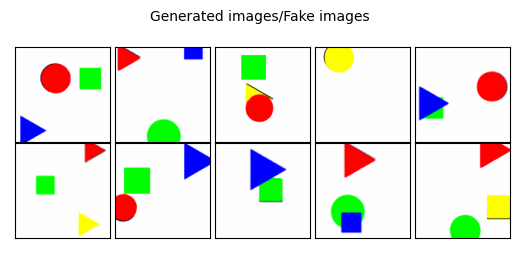

Early stopping processing....


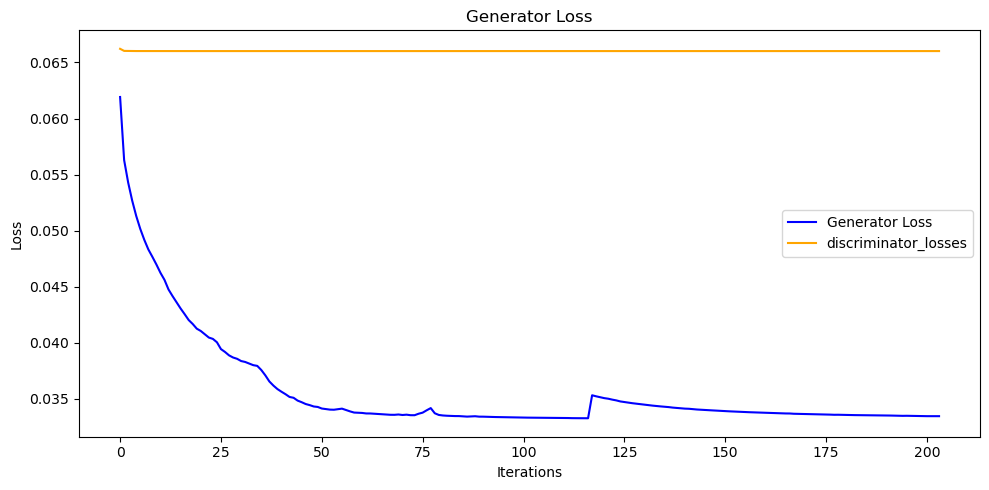

Epoch 81/100, Discriminator Loss: 6.601402575737223, Generator Loss: 3.3462111776918513
Epoch 81/100, Val Disc Loss: 6.601362332465157, Val Gen Loss: 0.07211339719120473
Final Average L1 Loss: Test-: 6.534924420217672 Val-: 7.0254488419445735 Train-: 4.122968010241145
Epoch 82/100, Discriminator Loss: 6.6014024811266765, Generator Loss: 3.3452410816875986
Epoch 82/100, Val Disc Loss: 6.60136498156048, Val Gen Loss: 0.07521070296033507
Final Average L1 Loss: Test-: 6.8653926312450375 Val-: 7.399330322172434 Train-: 4.693772548771634
Epoch 83/100, Discriminator Loss: 6.601402508158262, Generator Loss: 3.3444179631685182
Epoch 83/100, Val Disc Loss: 6.601364555813018, Val Gen Loss: 0.06694745398052629
Final Average L1 Loss: Test-: 6.1131926578661755 Val-: 6.679534904717927 Train-: 3.8482787461355836
Epoch 84/100, Discriminator Loss: 6.601402521674054, Generator Loss: 3.3443914249100115
Epoch 84/100, Val Disc Loss: 6.601339200186351, Val Gen Loss: 0.07197373502311252
Final Average L1 Loss:

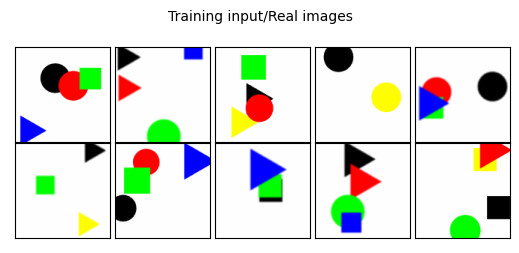

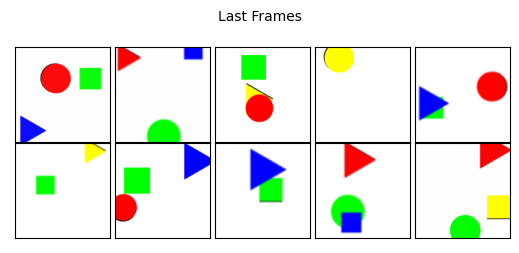

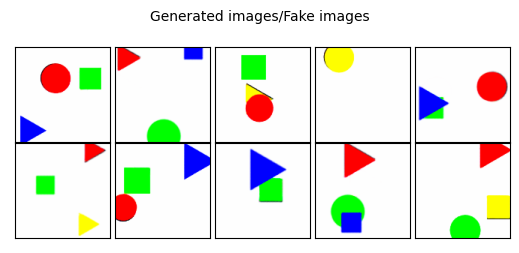

Early stopping processing....


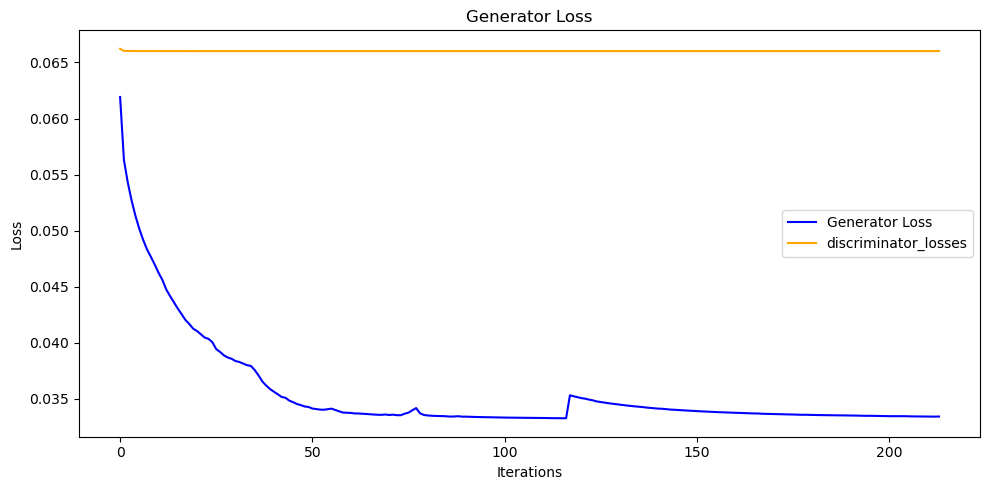

Epoch 91/100, Discriminator Loss: 6.601402710895149, Generator Loss: 3.3417429986183875
Epoch 91/100, Val Disc Loss: 6.6013603456436645, Val Gen Loss: 0.06851747609852325
Final Average L1 Loss: Test-: 6.311573235998078 Val-: 6.781938552324261 Train-: 4.131823261806957
Epoch 92/100, Discriminator Loss: 6.601402927147829, Generator Loss: 3.3420390823260453
Epoch 92/100, Val Disc Loss: 6.601391661734808, Val Gen Loss: 0.06284412802270953
Final Average L1 Loss: Test-: 6.232433065417267 Val-: 6.389511852628655 Train-: 3.587358922627913
Epoch 93/100, Discriminator Loss: 6.601403332621603, Generator Loss: 3.3418672560564247
Epoch 93/100, Val Disc Loss: 6.601403204221574, Val Gen Loss: 0.06993891309118934
Final Average L1 Loss: Test-: 6.8549604879485235 Val-: 7.1263047570865306 Train-: 4.064584807693418
Epoch 94/100, Discriminator Loss: 6.601402913632036, Generator Loss: 3.3402173427227138
Epoch 94/100, Val Disc Loss: 6.601348755851625, Val Gen Loss: 0.06571613762172915
Final Average L1 Loss: 

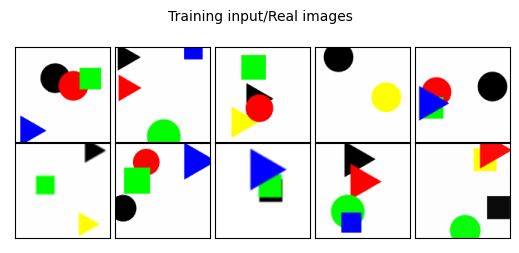

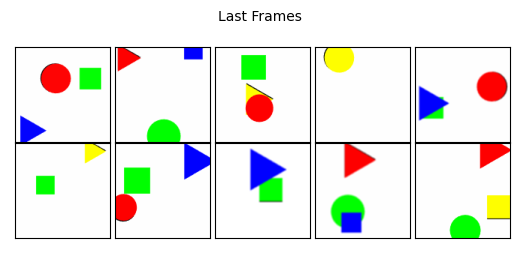

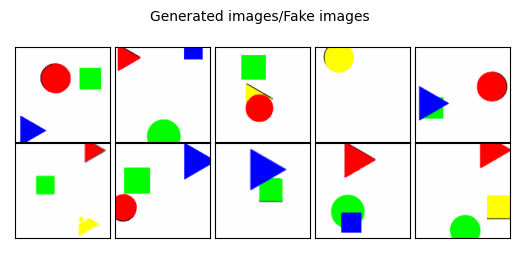

Early stopping processing....


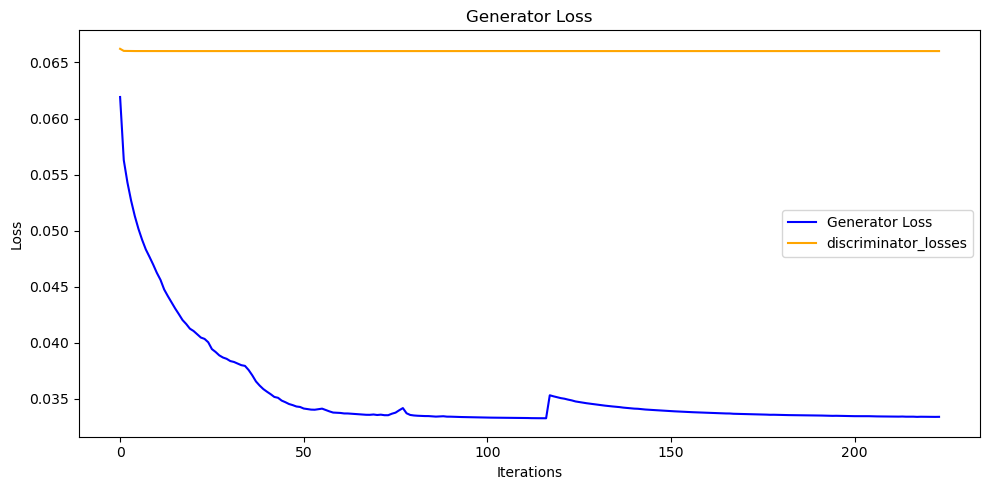

In [130]:
## cGAN Training 
    # Simultaneously running discriminator and generator over 1000 epochs
    # Appending average loss for both Gen() and Disc()
    # Evaluating Gen and Disc with Validation dataloader
    # Appending Average loss for Gen() and Disc() validation loss
    # Evaluating L1 Loss metric on testing, validation and training dataset on real and generated image
    # Leanring rate schdulting wrt validation loss on both Gen and Disc
    
## Evaluation While training
    # Printing training Gen and Disc avereage loss
    # Prining Validation Gen and Disc Loss
    # Calculating SSIM Scores every 10 epochs 
    # Visual inscpection of First frame, last frame and generated last frame 

num_epoch = 100
past_losses = []
best_val_loss = 100000000

patience = 10
no_improvement_counter = 0
current_disc_lr = d_optimizer.param_groups[0]['lr']
current_gen_lr = g_optimizer.param_groups[0]['lr']
print(f'Current Disc Learning Rate: {current_disc_lr}')
print(f'Current Gen Learning Rate: {current_gen_lr}')

for epoch in range(num_epoch):
    current_disc_lr = d_optimizer.param_groups[0]['lr']
    current_gen_lr = g_optimizer.param_groups[0]['lr']
    total_disc_loss = 0
    total_gen_loss = 0
    for batch_idx, (first_frame, last_frame) in enumerate(train_dataloader):
        first_frame, last_frame = first_frame.to(device), last_frame.to(device)
        first_frame=first_frame.float()
        last_frame=last_frame.float()
        generator.train()
        discriminator.train()
        batch_size = first_frame.size(0)
        
        disc_loss = discriminator_train_step(batch_size, discriminator, generator, d_optimizer, 
                                             criterion, first_frame, last_frame)
        
        gen_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer,
                                        criterion, first_frame)
        
        total_disc_loss += disc_loss
        total_gen_loss += gen_loss
    
    avg_disc_loss = total_disc_loss/len(train_dataloader.dataset)
    avg_gen_loss = total_gen_loss/len(train_dataloader.dataset)
   
    discriminator_losses_2.append(avg_disc_loss)
    generator_losses_2.append(avg_gen_loss)
    
    print(f'\033[91mEpoch {epoch + 1}/{num_epoch}, Discriminator Loss: {avg_disc_loss * 100}, Generator Loss: {avg_gen_loss * 100}\033[0m') ## "*100" is scaaling factor
            

    avg_val_gen_loss,avg_val_disc_loss = validation_step(generator,discriminator, val_dataloader, criterion, epoch, device)
    validation_gen_losses_2.append(avg_val_gen_loss)
    validation_disc_losses_2.append(avg_val_disc_loss)
       
    
    average_l1_loss_test = L1Loss_metric(test_dataloader, generator)
    average_l1_loss_val = L1Loss_metric(val_dataloader, generator)
    average_l1_loss_train = L1Loss_metric(train_dataloader, generator)
    print(f"Final Average L1 Loss: Test-: {average_l1_loss_test * 10000} Val-: {average_l1_loss_val * 10000} Train-: {average_l1_loss_train * 10000}") ## "*10000" is scaaling factor
    past_losses.append(average_l1_loss_test)

    # Metric evaluation to check prev 10 loss to find the trend of the loss (Increasing or decreasing)
    if (len(past_losses) >= 10 and (epoch + 1) % 10 == 0):
        past_losses = past_losses[-10:]
        trend = "Decreasing" if all(past_losses[i] > past_losses[i + 1] for i in range(len(past_losses) - 1)) else "Not Strictly Decreasing"
        print(f'Testing DT - Last 10 Average L1 Loss Trend: {trend}')
        

## Metric inspection while training

     ## SSIM score evaluation     
    if (epoch + 1) % 10 == 0:
        average_ssim_train = ssim_eval_color(train_dataloader, generator)
        print(f"\033[92mAverage SSIM Score for Training: {average_ssim_train * 100}\033[0m")

        average_ssim_val = ssim_eval_color(val_dataloader, generator)
        print(f"\033[92mAverage SSIM Score for Validation: {average_ssim_val * 100}\033[0m")

        average_ssim_test = ssim_eval_color(test_dataloader, generator) 
        print(f"\033[92mAverage SSIM Score for testing: {average_ssim_test * 100}\033[0m")
        
        ## Visual inspection of the frames
        validation_plot(generator, val_dataloader)
    
    ## Checks validation loss every 5 epochs and saves the best model
    if (epoch + 1) % 5 == 0:
        if avg_val_gen_loss < best_val_loss:
            print(f'Early stopping processing....')
            best_val_loss = avg_val_gen_loss
            best_model = generator.state_dict()
            torch.save(best_model, 'best_generator_model.pth')
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1
            
    if no_improvement_counter >= patience:
        print(f'Early stopping at epoch {epoch + 1} as there is no improvement for {patience} consecutive epochs.')
        no_improvement_counter = 0
        # Break
    
    ## Learning rate scheduling
    disc_scheduler.step(avg_val_disc_loss)
    gen_scheduler.step(avg_val_gen_loss)
    new_gen_lr = g_optimizer.param_groups[0]['lr']
    new_disc_lr = d_optimizer.param_groups[0]['lr']

    ## printing Lr whenever it changes
    if new_gen_lr != current_gen_lr:
        print(f'\033[95mGenerator Learning Rate changed: {current_gen_lr} -> {new_gen_lr}\033[0m')
        current_gen_lr = new_gen_lr

    if new_disc_lr != current_disc_lr:
        print(f'\033[95mDiscriminator Learning Rate changed: {current_disc_lr} -> {new_disc_lr}\033[0m')
        current_disc_lr = new_disc_lr

    ## Plotting loss graphs    
    if (epoch + 1) % 10 == 0:
        plot_loss(discriminator_losses_2, generator_losses_2)
        # plot_loss(validation_disc_losses_2, validation_gen_losses_2)
        # plot_loss_all(discriminator_losses_2, generator_losses_2, validation_disc_losses_2, validation_gen_losses_2)
         
        
        

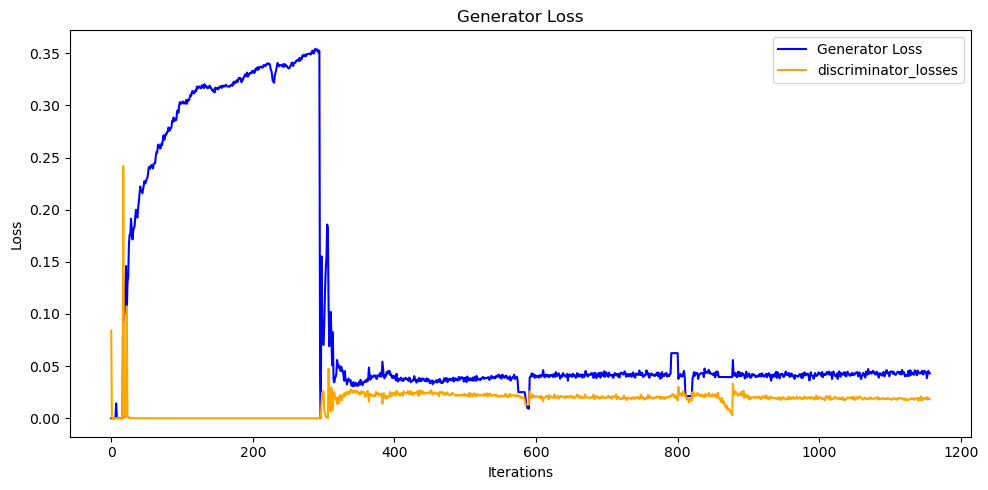

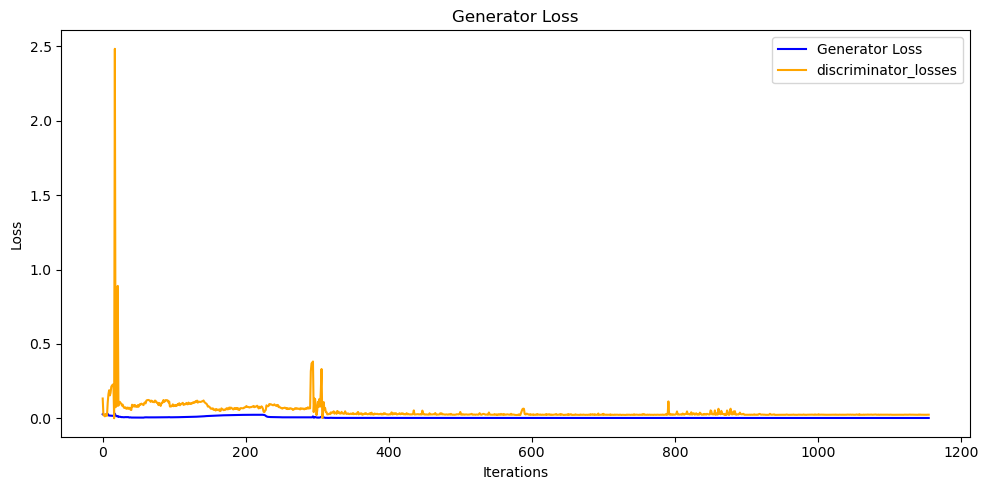

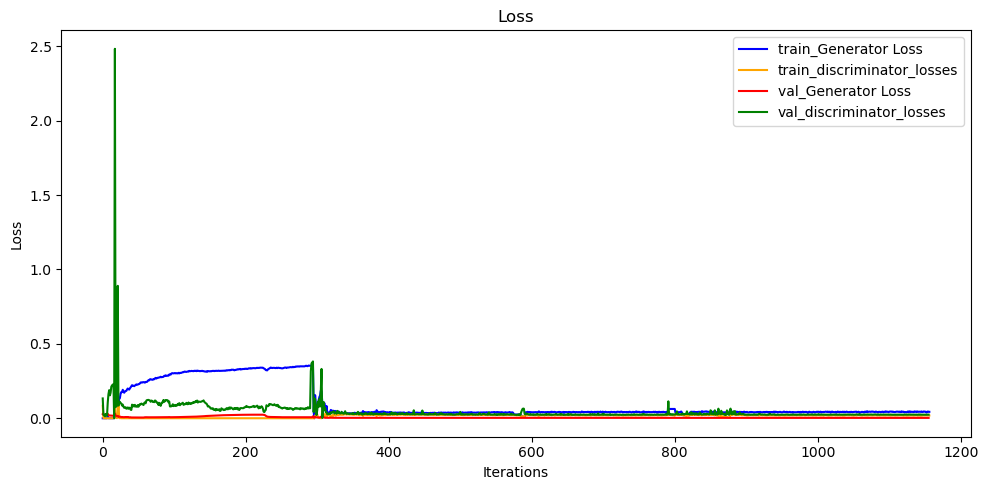

In [88]:
## Plotting the Loss ( almost 1000 Epochs)
plot_loss(discriminator_losses_1, generator_losses_1)
plot_loss(validation_disc_losses_1, validation_gen_losses_1)
plot_loss_all(discriminator_losses_1, generator_losses_1, validation_disc_losses_1, validation_gen_losses_1)

In [ ]:

## Save generator and discriminator models
torch.save(generator.state_dict(), 'generator_model_updated_1.pth')
torch.save(discriminator.state_dict(), 'discriminator_model_updated_1.pth')
torch.save(generator_losses_2, 'gen_loss_values_1.pth')
torch.save(discriminator_losses_2, 'disc_loss_values_1.pth')
torch.save(validation_gen_losses_2, 'val_gen_loss_values_1.pth')
torch.save(validation_disc_losses_2, 'val_disc_loss_values_1.pth')

## Load saved models later (if needed)
# generator.load_state_dict(torch.load('generator_model_updated_1.pth'))
# discriminator.load_state_dict(torch.load('discriminator_model_updated_1.pth'))
# generator_losses_1 = torch.load('gen_loss_values.pth')
# discriminator_losses_1 = torch.load('disc_loss_values.pth')
# validation_gen_losses_1 = torch.load('val_gen_loss_values_1.pth')
# val_disc_loss_values_1 = torch.load('val_disc_loss_values_1.pth')

### Evaluation

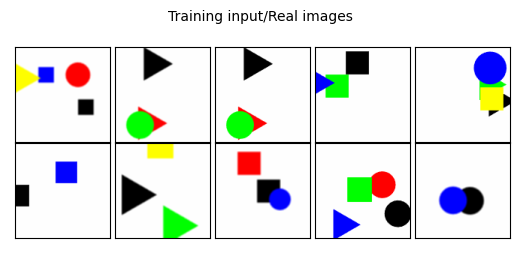

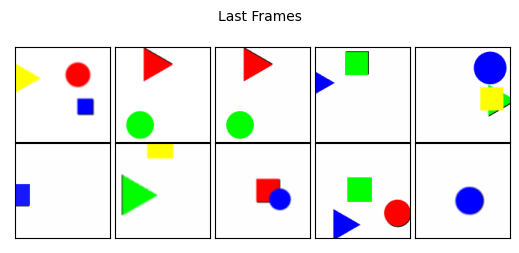

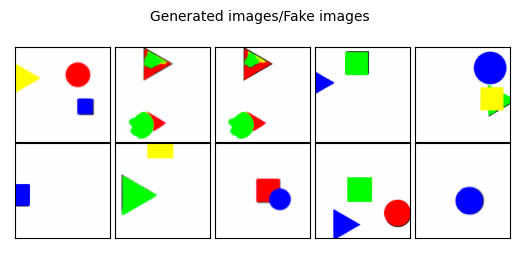

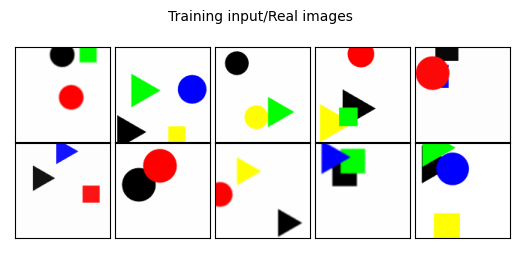

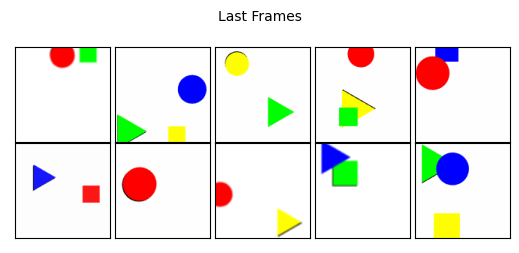

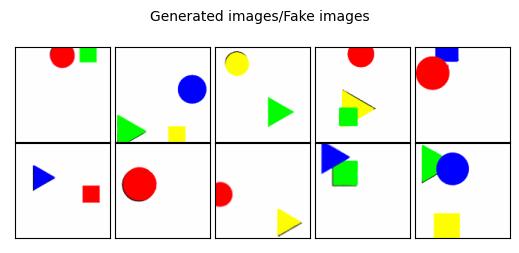

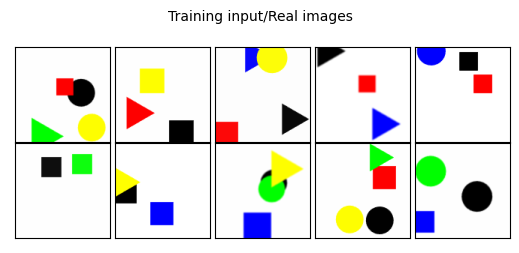

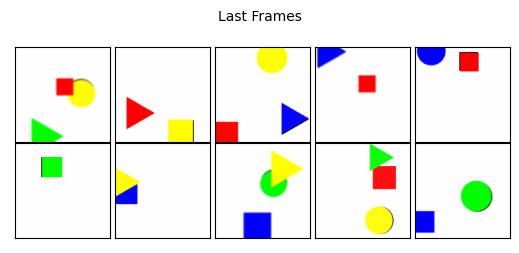

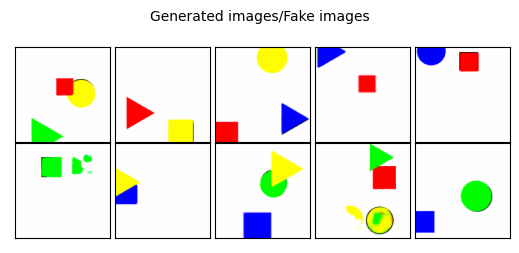

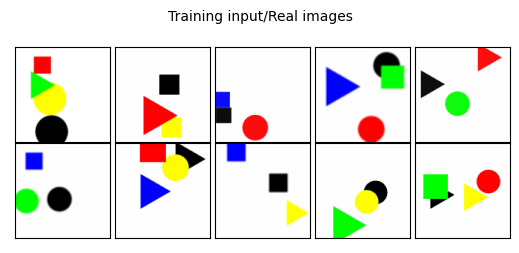

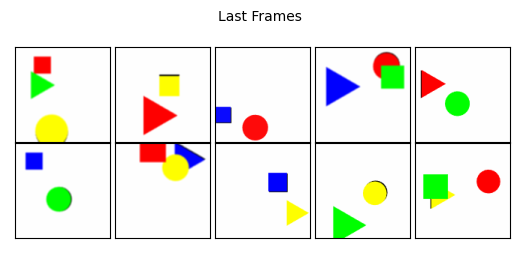

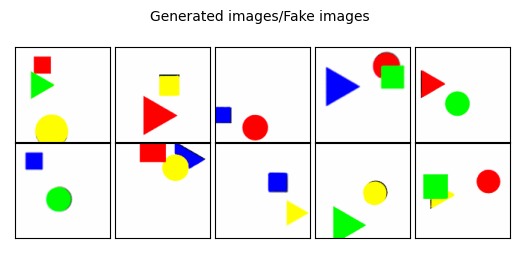

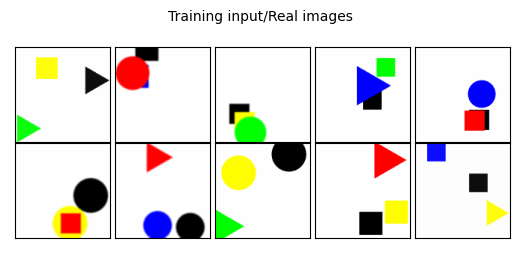

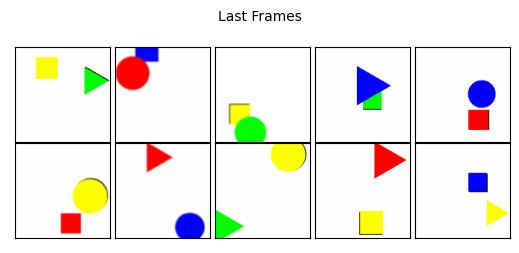

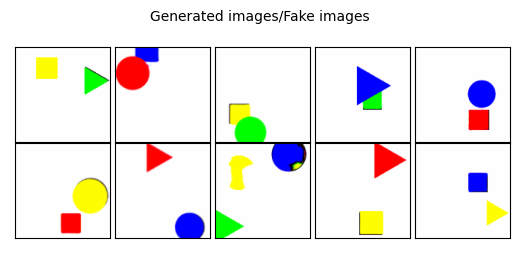

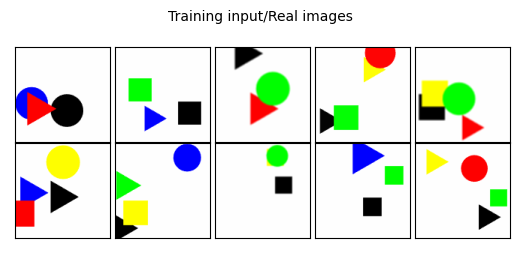

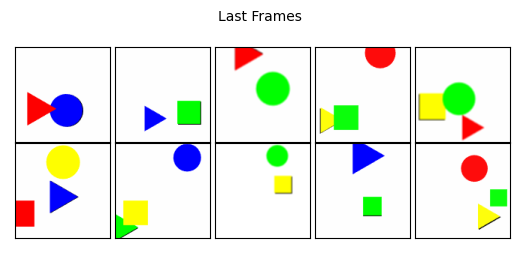

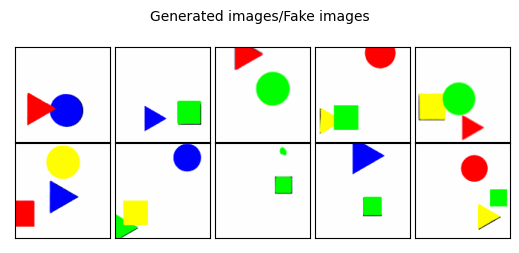

In [131]:
## Evaluation on test dataset (Visual inspection)
for batch_idx, (val_first_frame, val_last_frame) in enumerate(test_dataloader):
    val_first_frame, val_last_frame = val_first_frame.to(device), val_last_frame.to(device)
    val_first_frame=val_first_frame.float()
    val_last_frame=val_last_frame.float()        
    
    generator.eval()
    with torch.no_grad():
        val_generated_image = generator(val_first_frame)
    GAN.results(val_first_frame.cpu(), val_last_frame.cpu(), val_generated_image.cpu(), nimages=4, nrow=5)

In [26]:
# Compute L1 Score of the dataloader
def L1Loss_metric(dataloader, generator):
    total_l1_loss = 0.0

    for batch_idx, (ff, lf) in enumerate(dataloader):
        ff, lf = ff.to(device), lf.to(device)
        ff = ff.float()
        lf = lf.float()

        generator.eval()
        with torch.no_grad():
            g_image = generator(ff)

        # Calculate L1 Loss for each pair
        l1_loss = F.l1_loss(g_image, lf)
        total_l1_loss += l1_loss.item()

    # Calculate average L1 loss
    average_l1_loss = total_l1_loss / len(dataloader.dataset)
  
    return average_l1_loss

#### Uncoment and use to evaluate the loaders
# L1Loss_metric(test_dataloader, generator)   
# L1Loss_metric(val_dataloader, generator)  
# L1Loss_metric(train_dataloader, generator)  

In [27]:
## SSIM score calculation

def calculate_ssim(real_image, generated_image):
    """
    Calculate the Structural Similarity Index (SSIM) between two images.
    
    Args:
        real_image (torch.Tensor): The ground truth image.
        generated_image (torch.Tensor): The generated image to compare with the ground truth.

    Returns:
        value: The average SSIM score across all channels.
    """    
    # Convert images to numpy arrays
    real_array = real_image.cpu().detach().numpy().squeeze().transpose((1, 2, 0))
    generated_array = generated_image.cpu().detach().numpy().squeeze().transpose((1, 2, 0))

    # Calculate SSIM for each channel
    ssim_values = torch.tensor([
        ssim(real_channel, generated_channel, full=True, data_range=1)[0]
        for real_channel, generated_channel in zip(np.rollaxis(real_array, 2), np.rollaxis(generated_array, 2))
    ])

    average_ssim = ssim_values.mean()
    return average_ssim

def ssim_eval_color(dataloader, generator):
    """
    Evaluate the SSIM score for a dataset using a generator model.
    
    Args:
        dataloader : Dataloader for the dataset to evaluate.
        generator (torch.nn.Module): The generator model to produce images.

    Returns:
        Value: The average SSIM score across all pairs of real and generated images.
    """
    total_ssim = 0.0
    total_pairs = 0

    for idx, (first_frame, last_frame) in enumerate(dataloader):
        first_frame, last_frame = first_frame.to(device), last_frame.to(device)
        first_frame = first_frame.float()
        last_frame = last_frame.float()

        generator.eval()
        with torch.no_grad():
            generated_image = generator(first_frame)

        # SSIM for each pair
        for i in range(first_frame.size(0)):
            ssim_score = calculate_ssim(last_frame[i], generated_image[i])

            total_ssim += ssim_score
            total_pairs += 1

    average_ssim = total_ssim / total_pairs
    
    return average_ssim

##### Uncomment and use
# average_ssim_train, total_pairs  = ssim_eval_color(train_dataloader, generator)
# print(f"Average SSIM Score for Training: {average_ssim_train * 100},Pairs: {total_pairs}")

# average_ssim_val, total_pairs = ssim_eval_color(val_dataloader, generator)
# print(f"Average SSIM Score for Validation: {average_ssim_val * 100},Pairs: {total_pairs}")

# average_ssim_test, total_pairs = ssim_eval_color(test_dataloader, generator)
# print(f"Average SSIM Score for Testing: {average_ssim_test * 100},Pairs: {total_pairs}")
